In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import lxml.etree as ET
from bs4 import BeautifulSoup
import os
import spacy
import string
import re
import numpy as np
from spacy.symbols import ORTH
from pathlib import Path
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import cv2
import matplotlib.pyplot as plt

In [6]:
IMG_PATH = Path("./generative-dog-images/all-dogs")
ANNOT_PATH = Path("./generative-dog-images/Annotation")
list(IMG_PATH.iterdir())[:10]

[PosixPath('generative-dog-images/all-dogs/n02109961_16718.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02113799_5009.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02091032_6587.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02106166_1429.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02093754_2276.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02107683_4411.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02094114_2625.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02088094_8631.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02097130_1289.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02095314_3084.jpg')]

In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

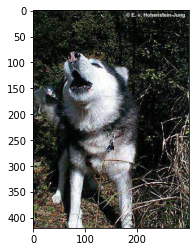

In [9]:
path = IMG_PATH/"n02109961_16718.jpg"
im = read_image(path)
plt.imshow(im)

In [10]:
im = cv2.imread(str(path))
im.shape

(420, 300, 3)

In [15]:
# let's look at the typical size of these images
images = list(IMG_PATH.iterdir())
annot_folders = list(ANNOT_PATH.iterdir())
annotations = []
for folder in annot_folders:
    breed_annots = list(folder.iterdir())
    annotations += breed_annots

In [16]:
images.sort(key = lambda x: str(x)[30:])
annotations.sort(key = lambda x: str(x)[33:])

In [17]:
images[:10]

[PosixPath('generative-dog-images/all-dogs/.DS_Store'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10074.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10131.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10621.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_1073.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10976.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11140.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11238.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11258.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11337.jpg')]

In [18]:
len(images)

20581

In [19]:
annotations[:10]

[PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10074'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10131'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10621'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_1073'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10976'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11140'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11238'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11258'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11337'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11477')]

In [20]:
len(annotations)

20580

In [21]:
annots_names = [str(x)[33:].split('/')[1] for x in annotations]
img_names = [str(x)[31:][:-4] for x in images]
set(annots_names)-set(img_names)

{'n02105855_2933'}

In [22]:
[str(x) for x in annotations].index('generative-dog-images/Annotation/n02105855-Shetland_sheepdog/n02105855_2933')

13680

In [23]:
annotations.pop(13680)

PosixPath('generative-dog-images/Annotation/n02105855-Shetland_sheepdog/n02105855_2933')

In [24]:
len(annotations)

20579

In [25]:
for i in range(len(annotations)):
    if str(images[i])[31:][:-4] != str(annotations[i])[33:].split('/')[1]:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499


6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919


9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997


11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
1146

13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
1317

14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847
14848
14849
14850
14851
14852
14853
14854
14855
14856
14857
14858
14859
14860
14861
14862
14863
14864
14865
14866
14867
14868
14869
14870
14871
14872
14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
14883
14884
14885
14886
14887
14888
14889
14890
14891
14892
14893
14894
14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
1496

16796
16797
16798
16799
16800
16801
16802
16803
16804
16805
16806
16807
16808
16809
16810
16811
16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823
16824
16825
16826
16827
16828
16829
16830
16831
16832
16833
16834
16835
16836
16837
16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854
16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865
16866
16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
1696

18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
18764
18765
18766
18767
18768
18769
18770
18771
18772
18773
18774
18775
18776
18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787
18788
18789
18790
18791
18792
1879

20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339
20340
20341
20342
20343
20344
20345
20346
20347
20348
20349
20350
20351
20352
20353
20354
20355
20356
20357
20358
20359
20360
20361
20362
20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395
20396
20397
20398
20399
20400
20401
20402
20403
20404
20405
20406
20407
20408
20409
20410
20411
20412
20413
20414
20415
20416
20417
20418
20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429
20430
20431
20432
20433
20434
20435
20436
20437
20438
20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
2046

In [26]:
for i in range(len(annotations)):
    with open(annotations[i]) as file:  
        data = file.read()
    parser = ET.XMLParser(recover=True)
    tree = ET.ElementTree(ET.fromstring(data, parser=parser))
    for object in tree.findall('object'):
        breeds = []
        breeds.append(object.find('name').text)
    annotations[i] = breeds[0]

In [27]:
annotations[:10]

['Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua']

In [28]:
len(annotations)

20579

### Dataset

In [29]:
puppy_data = pd.DataFrame(list(zip(images, annotations)), columns =['Image_Path', 'Breed']) 

In [30]:
puppy_data.head()

,Image_Path,Breed
0,generative-dog-images/all-dogs/.DS_Store,Chihuahua
1,generative-dog-images/all-dogs/n02085620_10074...,Chihuahua
2,generative-dog-images/all-dogs/n02085620_10131...,Chihuahua
3,generative-dog-images/all-dogs/n02085620_10621...,Chihuahua
4,generative-dog-images/all-dogs/n02085620_1073.jpg,Chihuahua


In [31]:
class PuppyBreedDataset(Dataset):
    def __init__(self, data):
        self.num_files = len(data)
        self.data = data
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx,:]
        y = row['Breed']
        print(y)
        img_path = row['Image_Path']
        print(img_path)
        x = read_image(str(img_path))
        x = cv2.resize(x, (100, 100))
        return np.rollaxis(x, 2), y

In [32]:
train_ds = PuppyBreedDataset(puppy_data)

In [33]:
len(train_ds)

20579

In [34]:
x, y = train_ds[2]
x.shape, y

Chihuahua
generative-dog-images/all-dogs/n02085620_10131.jpg


((3, 100, 100), 'Chihuahua')

In [35]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

In [36]:
len(train_loader)

322

### Model

In [37]:
resnet = models.resnet34(pretrained=True)
#resnet

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/mking/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [38]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [40]:
model = Net()

In [43]:
x, y = next(iter(train_loader))

standard_poodle
generative-dog-images/all-dogs/n02113799_6819.jpg
Lhasa
generative-dog-images/all-dogs/n02098413_2700.jpg
pug
generative-dog-images/all-dogs/n02110958_2611.jpg
silky_terrier
generative-dog-images/all-dogs/n02097658_3693.jpg
pug
generative-dog-images/all-dogs/n02110958_14654.jpg
Staffordshire_bullterrier
generative-dog-images/all-dogs/n02093256_3306.jpg
Old_English_sheepdog
generative-dog-images/all-dogs/n02105641_5577.jpg
Pembroke
generative-dog-images/all-dogs/n02113023_7062.jpg
dingo
generative-dog-images/all-dogs/n02115641_4951.jpg
basset
generative-dog-images/all-dogs/n02088238_2674.jpg
boxer
generative-dog-images/all-dogs/n02108089_4681.jpg
miniature_schnauzer
generative-dog-images/all-dogs/n02097047_2487.jpg
Labrador_retriever
generative-dog-images/all-dogs/n02099712_5017.jpg
Italian_greyhound
generative-dog-images/all-dogs/n02091032_3050.jpg
Brittany_spaniel
generative-dog-images/all-dogs/n02101388_10107.jpg
Eskimo_dog
generative-dog-images/all-dogs/n02109961_630

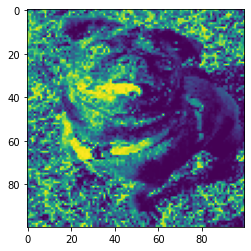

In [44]:
plt.imshow(x[2][0])

In [45]:
y[2]

'pug'

In [46]:
x = x.float()
y = y
x.shape

torch.Size([64, 3, 100, 100])

In [47]:
x

tensor([[[[173., 164., 168.,  ..., 241., 242., 244.],
          [140., 128., 131.,  ..., 242., 242., 240.],
          [110., 112., 109.,  ..., 241., 243., 247.],
          ...,
          [198., 177., 170.,  ..., 236., 240., 234.],
          [175., 186., 119.,  ..., 242., 240., 236.],
          [ 69.,  97., 135.,  ..., 248., 227., 219.]],

         [[113., 104., 108.,  ..., 227., 225., 225.],
          [ 82.,  73.,  73.,  ..., 243., 242., 242.],
          [ 67.,  69.,  66.,  ..., 237., 246., 241.],
          ...,
          [139., 113., 114.,  ..., 196., 202., 213.],
          [123., 128.,  64.,  ..., 237., 192., 176.],
          [ 32.,  79.,  90.,  ..., 237., 178., 157.]],

         [[ 61.,  52.,  56.,  ..., 154., 156., 156.],
          [ 42.,  32.,  33.,  ..., 173., 178., 177.],
          [ 35.,  35.,  34.,  ..., 166., 177., 179.],
          ...,
          [ 83.,  65.,  67.,  ..., 127., 137., 148.],
          [ 73.,  78.,  23.,  ..., 173., 128., 114.],
          [  6.,  43.,  48.,  ...

In [48]:
x_features = model.features1(x)
x_features.shape

torch.Size([64, 128, 13, 13])

In [49]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([64, 512, 4, 4])

In [50]:
x_features2 = F.relu(x_features2)

In [51]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [52]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [53]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [54]:
y_hat

tensor([[ 0.2768],
        [ 0.9301],
        [-1.2433],
        [ 0.6653],
        [-0.3716],
        [ 0.1550],
        [-1.0612],
        [ 0.1567],
        [-0.2494],
        [ 0.8284],
        [ 0.4033],
        [-0.9915],
        [-1.8238],
        [-0.5068],
        [ 0.5528],
        [ 0.7673],
        [-0.1450],
        [-0.2137],
        [ 0.4374],
        [ 0.8635],
        [ 0.4837],
        [-0.4525],
        [ 1.1897],
        [ 1.0944],
        [ 0.8580],
        [-1.9785],
        [-1.2371],
        [-0.2287],
        [-0.5992],
        [ 0.2347],
        [ 0.9439],
        [ 0.9857],
        [ 0.0425],
        [ 0.5883],
        [-0.2928],
        [-0.1361],
        [-0.5083],
        [ 0.7368],
        [-0.2131],
        [-0.5759],
        [-0.2774],
        [-0.2175],
        [ 0.2986],
        [ 0.4528],
        [ 0.5429],
        [-0.0078],
        [ 0.0580],
        [-0.4120],
        [-0.6711],
        [-0.0814],
        [ 0.0040],
        [ 1.0830],
        [ 0.